# 🏰 Project: Build a Mini-Transformer from Scratch

**Module 1: Transformer Fundamentals** | **Duration: ~3 hours** | **Type: Castle Project**

---

## Learning Objectives

By the end of this lab, you will be able to:

1. **Understand** the mathematical foundations of self-attention
2. **Implement** scaled dot-product attention from scratch
3. **Build** multi-head attention with learned projections
4. **Create** positional encodings to inject sequence order
5. **Assemble** a complete transformer block with residuals and layer norm
6. **Train** your mini-transformer on a character prediction task

## Concepts Covered

| Concept | Section |
|---------|--------|
| Self-Attention | 2 |
| Query-Key-Value | 2 |
| Scaled Dot-Product | 2 |
| Attention Scores | 3 |
| Multi-Head Attention | 4 |
| Positional Encoding | 5 |
| Feed-Forward Networks | 6 |
| Layer Normalization | 7 |
| Residual Connections | 7 |

## 1. Setup and Imports (~5 min)

First, let's import the libraries we'll need and set up our environment.

In [4]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

# For visualization
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1+cpu


## 2. Understanding Self-Attention (~30 min)

### 2.1 The Intuition

Self-attention allows each position in a sequence to "look at" all other positions and decide which ones are most relevant.

**Analogy**: Imagine you're reading a sentence:
> "The cat sat on the mat because it was tired."

When you read "it", your brain automatically refers back to "cat" to understand what "it" means. Self-attention does something similar—it creates connections between all words based on their relevance to each other.

### 2.2 Query, Key, Value (QKV)

Self-attention uses three learned transformations:

- **Query (Q)**: "What am I looking for?"
- **Key (K)**: "What do I contain that might be relevant?"
- **Value (V)**: "What information do I provide if I'm relevant?"

The attention mechanism works like a **soft dictionary lookup**:
1. Compare each Query with all Keys to get attention scores
2. Use scores to weight the Values
3. Sum the weighted Values to get the output

### 2.3 Scaled Dot-Product Attention

The attention formula is:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

Where:
- $QK^T$: Dot product between queries and keys (similarity scores)
- $\sqrt{d_k}$: Scaling factor to prevent large values
- $\text{softmax}$: Converts scores to probabilities (0-1, sum to 1)
- $V$: Values weighted by attention probabilities

In [5]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        Q: Queries (batch, seq_len, d_k) or (batch, heads, seq_len, d_k)
        K: Keys (batch, seq_len, d_k) or (batch, heads, seq_len, d_k)
        V: Values (batch, seq_len, d_v) or (batch, heads, seq_len, d_v)
        mask: Optional attention mask
        
    Returns:
        output: Weighted sum of values
        attention_weights: Attention probability distribution
    """
    d_k = Q.size(-1)
    
    # Step 1: Compute attention scores (QK^T)
    scores = torch.matmul(Q, K.transpose(-2, -1))
    
    # Step 2: Scale by sqrt(d_k) to prevent large values
    scores = scores / math.sqrt(d_k)
    
    # Step 3: Apply mask (if provided)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # Step 4: Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Step 5: Multiply by values
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights


# Test the attention function
seq_len, d_model = 4, 6
X = torch.randn(1, seq_len, d_model)

# Create Q, K, V projections
W_Q = nn.Linear(d_model, d_model, bias=False)
W_K = nn.Linear(d_model, d_model, bias=False)
W_V = nn.Linear(d_model, d_model, bias=False)

Q, K, V = W_Q(X), W_K(X), W_V(X)
output, attn_weights = scaled_dot_product_attention(Q, K, V)

print(f"Input shape: {X.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights:\n{attn_weights[0].detach().numpy().round(3)}")

Input shape: torch.Size([1, 4, 6])
Output shape: torch.Size([1, 4, 6])
Attention weights:
[[0.261 0.303 0.331 0.105]
 [0.287 0.272 0.235 0.206]
 [0.248 0.227 0.167 0.358]
 [0.275 0.268 0.224 0.232]]


## 3. Causal Masking for Autoregressive Models (~20 min)

For autoregressive models (like GPT), we need to prevent positions from attending to future positions. This is called **causal masking**.

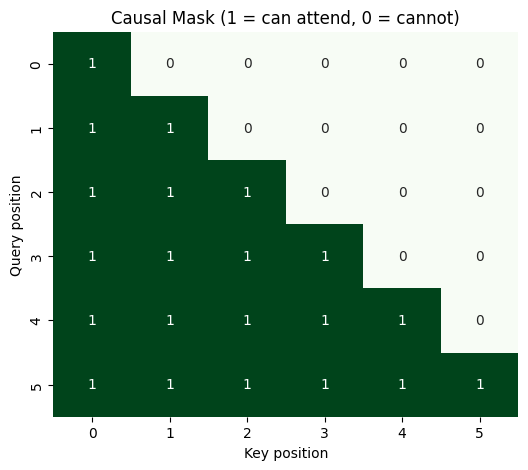

Masked attention weights:
[[1.    0.    0.    0.   ]
 [0.513 0.487 0.    0.   ]
 [0.386 0.353 0.26  0.   ]
 [0.275 0.268 0.224 0.232]]


In [6]:
def create_causal_mask(seq_len):
    """Create a causal (look-ahead) mask. Position i can only attend to positions <= i."""
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask

# Visualize causal mask
causal_mask = create_causal_mask(6)
plt.figure(figsize=(6, 5))
sns.heatmap(causal_mask.numpy(), annot=True, cmap='Greens', cbar=False)
plt.title('Causal Mask (1 = can attend, 0 = cannot)')
plt.xlabel('Key position')
plt.ylabel('Query position')
plt.show()

# Apply causal mask to attention
output_masked, attn_masked = scaled_dot_product_attention(Q, K, V, mask=create_causal_mask(seq_len))
print(f"Masked attention weights:\n{attn_masked[0].detach().numpy().round(3)}")

## 4. Multi-Head Attention (~30 min)

A single attention head can only focus on one type of relationship at a time. **Multi-head attention** runs multiple attention operations in parallel, allowing the model to:

1. Attend to information from different representation subspaces
2. Capture different types of relationships simultaneously
3. Provide richer, more expressive representations

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h) W^O$$

In [7]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention mechanism."""
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear projections and reshape for multi-head
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Adjust mask for multi-head format
        if mask is not None:
            mask = mask.unsqueeze(0).unsqueeze(0)
        
        # Apply attention
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)
        
        return self.dropout(output), attn_weights


# Test multi-head attention
mha = MultiHeadAttention(d_model=64, num_heads=8)
x = torch.randn(2, 10, 64)
output, attn = mha(x, x, x, create_causal_mask(10))
print(f"Multi-head attention output shape: {output.shape}")
print(f"Attention weights shape: {attn.shape} (batch, heads, queries, keys)")

Multi-head attention output shape: torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 8, 10, 10]) (batch, heads, queries, keys)


## 5. Positional Encoding (~25 min)

Self-attention is **permutation invariant**—it doesn't inherently know the order of tokens. Positional encodings inject sequence order information using sinusoidal functions:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

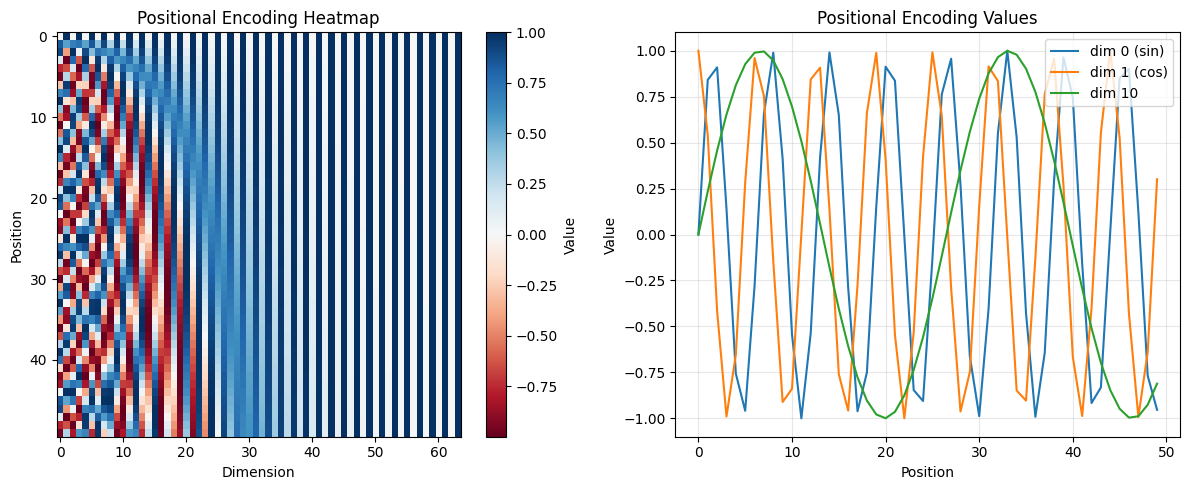

In [8]:
class PositionalEncoding(nn.Module):
    """Sinusoidal Positional Encoding."""
    
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# Visualize positional encodings
pos_encoder = PositionalEncoding(d_model=64)
pe = pos_encoder.pe[0, :50, :].numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(pe, aspect='auto', cmap='RdBu')
plt.colorbar(label='Value')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding Heatmap')

plt.subplot(1, 2, 2)
plt.plot(pe[:, 0], label='dim 0 (sin)')
plt.plot(pe[:, 1], label='dim 1 (cos)')
plt.plot(pe[:, 10], label='dim 10')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Positional Encoding Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Feed-Forward Networks (~20 min)

After attention, each position goes through a position-wise feed-forward network:

$$\text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2$$

In [9]:
class FeedForward(nn.Module):
    """Position-wise Feed-Forward Network."""
    
    def __init__(self, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model  # Default: 4x expansion
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))


# Test feed-forward network
ffn = FeedForward(d_model=64, d_ff=256)
x = torch.randn(2, 10, 64)
output = ffn(x)
print(f"FFN input shape: {x.shape}")
print(f"FFN output shape: {output.shape}")
print(f"FFN parameters: {sum(p.numel() for p in ffn.parameters()):,}")

FFN input shape: torch.Size([2, 10, 64])
FFN output shape: torch.Size([2, 10, 64])
FFN parameters: 33,088


## 7. Layer Normalization and Residual Connections (~20 min)

Layer Normalization normalizes across features (not batch), and residual connections add the input to the output for better gradient flow:

$$\text{output} = \text{LayerNorm}(x + \text{Sublayer}(x))$$

In [10]:
class TransformerBlock(nn.Module):
    """A single Transformer block with attention + FFN, both with residual connections and layer norm."""
    
    def __init__(self, d_model, num_heads, d_ff=None, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        # Pre-norm attention with residual
        attn_out, _ = self.attention(self.norm1(x), self.norm1(x), self.norm1(x), mask)
        x = x + attn_out  # Residual connection
        
        # Pre-norm feed-forward with residual
        ff_out = self.feed_forward(self.norm2(x))
        x = x + ff_out  # Residual connection
        
        return x


# Test transformer block
block = TransformerBlock(d_model=64, num_heads=4)
x = torch.randn(2, 10, 64)
output = block(x, create_causal_mask(10))
print(f"Transformer block output shape: {output.shape}")

Transformer block output shape: torch.Size([2, 10, 64])


## 8. Assembling the Complete Mini-Transformer (~30 min)

Now let's put everything together into a complete transformer model for next-token prediction!

In [11]:
class MiniTransformer(nn.Module):
    """A minimal Transformer model for next-token prediction."""
    
    def __init__(self, vocab_size, d_model=64, num_heads=4, num_layers=2, d_ff=None, max_len=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.final_norm = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size)
        
    def forward(self, x, mask=None):
        seq_len = x.size(1)
        if mask is None:
            mask = create_causal_mask(seq_len).to(x.device)
        
        # Embed tokens and scale
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        
        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, mask)
        
        x = self.final_norm(x)
        return self.output_proj(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Test the model
model = MiniTransformer(vocab_size=100, d_model=64, num_heads=4, num_layers=2)
x = torch.randint(0, 100, (4, 20))
logits = model(x)
print(f"Model parameters: {model.count_parameters():,}")
print(f"Input shape: {x.shape}")
print(f"Output logits shape: {logits.shape}")

Model parameters: 112,996
Input shape: torch.Size([4, 20])
Output logits shape: torch.Size([4, 20, 100])


## 9. Training on Character Prediction (~30 min)

Let's train our mini transformer on a simple task: predicting the next character in a sequence.

In [12]:
# Create a simple dataset with repeating patterns
text = "hello world! " * 100 + "transformers are amazing! " * 100 + "attention is all you need! " * 100

# Create character vocabulary
chars = sorted(list(set(text)))
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}
vocab_size = len(chars)

print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {''.join(chars)}")
print(f"Text length: {len(text)} characters")

# Encode the text
encoded = torch.tensor([char_to_idx[c] for c in text], dtype=torch.long)

# Create training sequences
def create_sequences(data, seq_len):
    sequences, targets = [], []
    for i in range(0, len(data) - seq_len - 1, seq_len):
        sequences.append(data[i:i+seq_len])
        targets.append(data[i+1:i+seq_len+1])
    return torch.stack(sequences), torch.stack(targets)

seq_len = 32
X, Y = create_sequences(encoded, seq_len)
print(f"\nNumber of sequences: {len(X)}")

Vocabulary size: 20
Characters:  !adefghilmnorstuwyz
Text length: 6600 characters

Number of sequences: 206


In [13]:
# Create model and training setup
model = MiniTransformer(vocab_size=vocab_size, d_model=64, num_heads=4, num_layers=2, dropout=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print(f"Model parameters: {model.count_parameters():,}")

# Training loop
def train_epoch(model, X, Y, optimizer, criterion, batch_size=32):
    model.train()
    total_loss, num_batches = 0, 0
    perm = torch.randperm(len(X))
    X, Y = X[perm], Y[perm]
    
    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size].to(device)
        batch_Y = Y[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits.view(-1, vocab_size), batch_Y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# Train
num_epochs = 20
losses = []
print("Training...")
for epoch in range(num_epochs):
    loss = train_epoch(model, X, Y, optimizer, criterion)
    losses.append(loss)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

Model parameters: 102,676
Training...
Epoch 5/20, Loss: 1.8738
Epoch 10/20, Loss: 1.0780
Epoch 15/20, Loss: 0.7363
Epoch 20/20, Loss: 0.5533


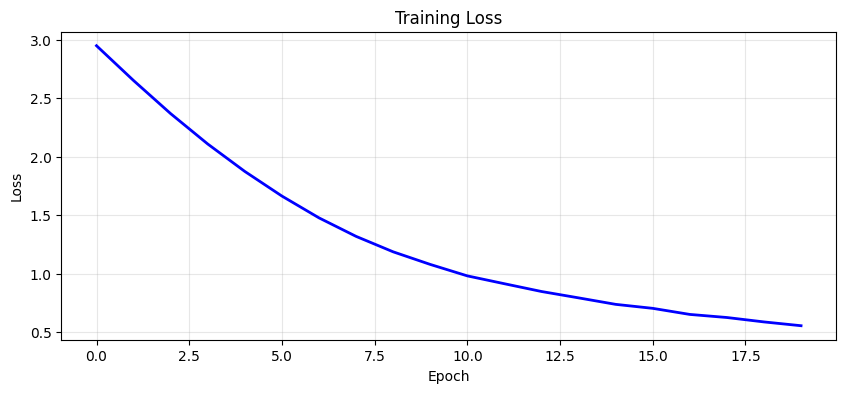

Generated text (temperature=1.0):
--------------------------------------------------
hello wo world! wo d! held! hellorld! helorllld! heldmd! woiorlworlorllorllorld! helo held! world! wo held

Generated text (temperature=0.5):
--------------------------------------------------
attention is alll you neeed! aten ation ion yon yon allll ated! n atten ationen n ion atis yon is is iou all a


In [14]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Generate text!
def generate_text(model, start_text, max_len=100, temperature=1.0):
    model.eval()
    tokens = torch.tensor([char_to_idx[c] for c in start_text], dtype=torch.long).unsqueeze(0).to(device)
    generated = list(start_text)
    
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(tokens)
            next_logits = logits[0, -1, :] / temperature
            probs = F.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
            generated.append(idx_to_char[next_token.item()])
    
    return ''.join(generated)

print("Generated text (temperature=1.0):")
print("-" * 50)
print(generate_text(model, "hello ", max_len=100, temperature=1.0))
print()
print("Generated text (temperature=0.5):")
print("-" * 50)
print(generate_text(model, "attention ", max_len=100, temperature=0.5))